In [1]:
%load_ext autoreload

%autoreload 2

In [23]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [3]:
from regression_classifier import *

In [4]:
df = pd.read_csv('./data/AB_NYC_2019_EDA.csv').drop(['Unnamed: 0'], axis=1)

target_name = 'price'

In [5]:
X, y = df.drop(columns=[target_name]), df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Test ClassRegressor

In [14]:
df.head()

,neighbourhood,price,availability_365,n-hood_group_Brooklyn,n-hood_group_Manhattan,n-hood_group_Queens,n-hood_group_Staten Island,room_type_Private room,room_type_Shared room,Manh_dist,Broo_dist,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,log_calculated_host_listings_count
0,92.669640,149,365,1,0,0,0,1,0,0.133675,0.025206,0.693147,2.302585,-1.560648,1.791759
1,252.614598,225,355,0,1,0,0,0,0,0.032827,0.108917,0.693147,3.828641,-0.967584,0.693147
2,109.915169,150,365,0,1,0,0,1,0,0.036737,0.158162,1.386294,0.000000,-0.328504,0.000000
3,140.791735,89,194,1,0,0,0,0,0,0.096037,0.036351,0.693147,5.602119,1.534714,0.000000
4,121.010757,80,0,0,1,0,0,0,0,0.027858,0.147596,2.397895,2.302585,-2.302585,0.000000


<AxesSubplot:>

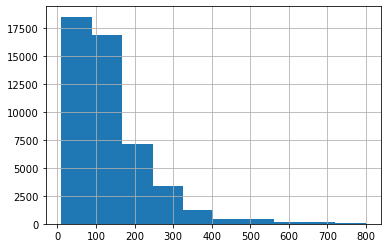

In [15]:
df[target_name].hist()

In [16]:
df[target_name].describe()

count    48410.000000
mean       137.575170
std        103.780081
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max        799.000000
Name: price, dtype: float64

In [70]:
clf = ClassRegressor(n_bins=5)
clf.fit(X_train_scaled, y_train)

In [71]:
pred_train = clf.predict(X_train_scaled, regression=True)
pred_test = clf.predict(X_test_scaled, regression=True)

print('Class regressor')
print('train mae', mean_absolute_error(y_train, pred_train))
print('test mae', mean_absolute_error(y_test, pred_test))

Class regressor
train mae 58.3138328785063
test mae 57.99512359980792


In [66]:
pd.Series(clf.y_classes).value_counts()

0    24823
1     7291
2     1141
3      419
4      213
dtype: int64

In [75]:
clf = ClassRegressor(n_bins=5, bins_calc_method='percentile')
clf.fit(X_train_scaled, y_train)
pred_train = clf.predict(X_train_scaled, regression=True)
pred_test = clf.predict(X_test_scaled, regression=True)

print('Class regressor')
print('train mae', mean_absolute_error(y_train, pred_train))
print('test mae', mean_absolute_error(y_test, pred_test))

Class regressor
train mae 55.011132465641026
test mae 54.79093739634413


In [68]:
pd.Series(clf.y_classes).value_counts()

0    7085
1    6908
4    6749
3    6724
2    6421
dtype: int64

In [19]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_scaled, y_train)


pred_train = dummy_regr.predict(X_train_scaled)
pred_test = dummy_regr.predict(X_test_scaled)

print('Dummy regressor')
print('train mae', mean_absolute_error(y_train, pred_train))
print('test mae', mean_absolute_error(y_test, pred_test))

Dummy regressor
train mae 73.40003703765083
test mae 73.39060713427676


# Test ClassRegressorEnsemble

In [20]:
N_BINS = 2
N_LEVELS = 3

class_reg = ClassRegressorEnsemble(n_bins=N_BINS, n_levels=N_LEVELS)

class_reg.fit(X_train_scaled, y_train)

In [21]:
pred_test = class_reg.predict(X_test_scaled)

In [22]:
pd.Series(pred_test).value_counts()

68.745752     7394
152.572647    6246
254.707027     877
469.063786       6
dtype: int64

In [23]:
pred_train = class_reg.predict(X_train_scaled)
pred_test = class_reg.predict(X_test_scaled)

print('Simple ClassRegressor ensemble')
print('train mae', mean_absolute_error(y_train, pred_train))
print('test mae', mean_absolute_error(y_test, pred_test))

Simple ClassRegressor ensemble
train mae 50.58294568478059
test mae 50.990203321910144


# Test large ClassRegressorEnsemble

In [34]:
N_BINS = 5
N_LEVELS = 3

class_reg = ClassRegressorEnsemble(n_bins=N_BINS, n_levels=N_LEVELS)

In [35]:
class_reg.fit(X_train_scaled, y_train)

In [36]:
pred_train = class_reg.predict(X_train_scaled)

In [37]:
print('Train errors')
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

measured_metrics["class_reg"] = dataframe_metrics(y_train, pred_train)
measured_metrics

Train errors


,error_type,class_reg
0,MAE,47.597818
1,RMSE,87.225821
2,R2,0.296675
3,MAPE,30.156956


In [38]:
pred_test = class_reg.predict(X_test_scaled)
print('Test errors')
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

measured_metrics["class_reg"] = dataframe_metrics(y_test, pred_test)
measured_metrics

Test errors


,error_type,class_reg
0,MAE,47.882856
1,RMSE,86.273592
2,R2,0.301653
3,MAPE,30.355857


## Best scores

In [40]:
class_reg = ClassRegressorEnsemble(n_bins=2, n_levels=5, bins_calc_method='equal', leaf_model=None)
class_reg.fit(X_train_scaled, y_train)
pred_test = class_reg.predict(X_test_scaled)
measured_metrics["class_reg"] = dataframe_metrics(y_test, pred_test)
measured_metrics

,error_type,class_reg
0,MAE,47.453174
1,RMSE,84.152413
2,R2,0.335570
3,MAPE,31.147789


## Percentile methode

In [85]:
class_reg = ClassRegressorEnsemble(n_bins=100, n_levels=1, bins_calc_method='percentile', leaf_model=None)
class_reg.fit(X_train_scaled, y_train)
pred_test = class_reg.predict(X_test_scaled)
measured_metrics["class_reg"] = dataframe_metrics(y_test, pred_test)
measured_metrics

,error_type,class_reg
0,MAE,50.645577
1,RMSE,90.554539
2,R2,0.230628
3,MAPE,35.338208


## Percentile with linear regression

In [86]:
class_reg = ClassRegressorEnsemble(n_bins=100, n_levels=1, bins_calc_method='percentile', leaf_model=LinearRegression)
class_reg.fit(X_train_scaled, y_train)
pred_test = class_reg.predict(X_test_scaled)
measured_metrics["class_reg"] = dataframe_metrics(y_test, pred_test)
measured_metrics

,error_type,class_reg
0,MAE,50.794018
1,RMSE,91.257705
2,R2,0.218633
3,MAPE,35.421157


In [30]:
lgbm_reg = LGBMRegressor()

lgbm_reg.fit(X_train_scaled, y_train)

measured_metrics["baseline_lgbm"] = dataframe_metrics(y_test, lgbm_reg.predict(X_test_scaled))
measured_metrics

,error_type,class_reg,baseline_lgbm
0,MAE,47.882856,44.184880
1,RMSE,86.273592,71.781541
2,R2,0.301653,0.516561
3,MAPE,30.355857,35.340550
